In [ ]:
import logging
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from pathlib import Path
from vangja.components import LinearTrend, FourierSeasonality, Constant
from vangja.data_utils import (
    download_data,
    process_data,
    generate_train_test_df_around_point,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

Importing plotly failed. Interactive plots will not work.


# Fetch data

In [2]:
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

# Generate models

In [6]:
model_components = [
    [LinearTrend(changepoint_range=1, allow_tune=False)],
    [
        FourierSeasonality(period=365.25, series_order=10, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    [
        FourierSeasonality(period=365.25 / 4, series_order=n, allow_tune=allow_tune)
        for n in range(7, 10)
        for allow_tune in [True, False]
    ],
    [
        FourierSeasonality(period=365.25 / 12, series_order=n, allow_tune=allow_tune)
        for n in range(4, 7)
        for allow_tune in [True, False]
    ],
    [
        FourierSeasonality(period=7, series_order=3, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
]

In [7]:
q = [(0, [mc]) for mc in model_components[0]]
models = []

while len(q):
    level, model = q.pop(0)
    if level + 1 == len(model_components):
        models.append(model)
        continue

    mcs = model_components[level + 1]
    for mc in mcs:
        q.append((level + 1, model + [Constant(lower=-1, upper=1) * mc]))
        q.append((level + 1, model + [mc]))
        q.append((level + 1, model))

In [8]:
def sum_models(models):
    s = None
    for model in models:
        if s is None:
            s = model
        else:
            s += model

    return s

In [9]:
models = (
    [
        LinearTrend() * (FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3)),
        LinearTrend() * FourierSeasonality(365.25, 10),
        LinearTrend() * FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10),
        LinearTrend() + FourierSeasonality(7, 3),
    ]
    + [
        model[0] * sum_models(model[1:]) if len(model) > 1 else model[0]
        for model in models
    ]
    + [sum_models(model) if len(model) > 1 else model[0] for model in models]
)

In [10]:
str_models = {""}
final_models = []
for model in models:
    str_model = str(model)
    if str_model in str_models:
        continue

    str_models.add(str_model)
    final_models.append(model)

len(final_models)

15

In [ ]:
str_models

{'',
 'LT(n=25,r=0.8,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=Fals

# Run on validation set

In [ ]:
point = "2014-01-01"


def set_tune_method(model, tune_method):
    if hasattr(model, "left"):
        set_tune_method(model.left, tune_method)
        set_tune_method(model.right, tune_method)

    if hasattr(model, "beta_sd"):
        model.tune_method = tune_method
        model.beta_sd = 0.01


val_tickers = []
for gspc_ticker in tqdm(gspc_tickers):
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is not None:
        val_tickers.append(check)


for context_size in range(10, 90, 10):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 80, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    for tune_method in ["linear", "simple", "same"]:
        for model in final_models:
            set_tune_method(model, tune_method)
            model_name = (
                str(model)
                .replace(",", "_")
                .replace("*", "MUL")
                .replace("+", "ADD")
                .replace(".", "_")
                .replace("=", "_")
            )
            print(f"context: {context_size} years, tune: {tune_method}, {model}")
            model.fit(train_df_smp, progressbar=False)
            yhat = model.predict(365)
            print(
                f"context mape: {model.metrics(test_df_smp, yhat, pool_cols='series')['mape'].iloc[0]}"
            )

            model_metrics = []
            for val_ticker in tqdm(val_tickers):
                train_df_tickers, test_df_tickers, scales_tickers = val_ticker
                model.tune(train_df_tickers, progressbar=False)
                yhat = model.predict(365)
                model_metrics.append(
                    model.metrics(test_df_tickers, yhat, pool_cols="series")
                )

            final_metrics = pd.concat(model_metrics)
            final_metrics.to_csv(
                Path("./")
                / "out"
                / f"vangja_{tune_method}_{context_size}_{model_name}.csv"
            )
            print(f"val mape: {final_metrics['mape'].mean()}")

# Test prophet

In [14]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [15]:
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=True, point=point
)
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
)

In [16]:
context_prophet = Prophet(seasonality_mode="multiplicative")
context_prophet.fit(train_df_smp[0])
context_future = context_prophet.make_future_dataframe(
    periods=365, include_history=True
)
context_yhat = context_prophet.predict(context_future)
context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
context_metrics

,mse,rmse,mae,mape
^GSPC,0.075807,0.275331,0.272638,0.259551


In [17]:
train_df_ticker[0]

,typical_price,ds,series,y
18901,104.404131,2013-10-02,PRGO,0.796233
18902,104.943030,2013-10-03,PRGO,0.800343
18903,106.336274,2013-10-04,PRGO,0.810968
18904,106.851518,2013-10-05,PRGO,0.814898
18905,107.366762,2013-10-06,PRGO,0.818827
...,...,...,...,...
18987,127.067767,2013-12-27,PRGO,0.969076
18988,127.290725,2013-12-28,PRGO,0.970776
18989,127.513683,2013-12-29,PRGO,0.972477
18990,127.736640,2013-12-30,PRGO,0.974177


In [20]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_ticker, test_df_tickers)):
    # if df["series"].iloc[0] not in good_stocks:
    #     continue
    
    prophet = Prophet(
        seasonality_mode="multiplicative",
        n_changepoints=25,
        yearly_seasonality=True,
        weekly_seasonality=True,
    )
    # prophet.add_regressor("smp_weekly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yearly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yhat", standardize=False, mode="additive")

    train_df = df.copy()
    # train_df["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # train_df["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # train_df["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet.fit(train_df)

    future = prophet.make_future_dataframe(periods=365, include_history=True)
    # future["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # future["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # future["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
prophet_metrics.to_csv("prophet_results_2014.csv")
prophet_metrics["mape"].mean()

437it [35:23,  4.86s/it]


26.3301940204345

/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing py

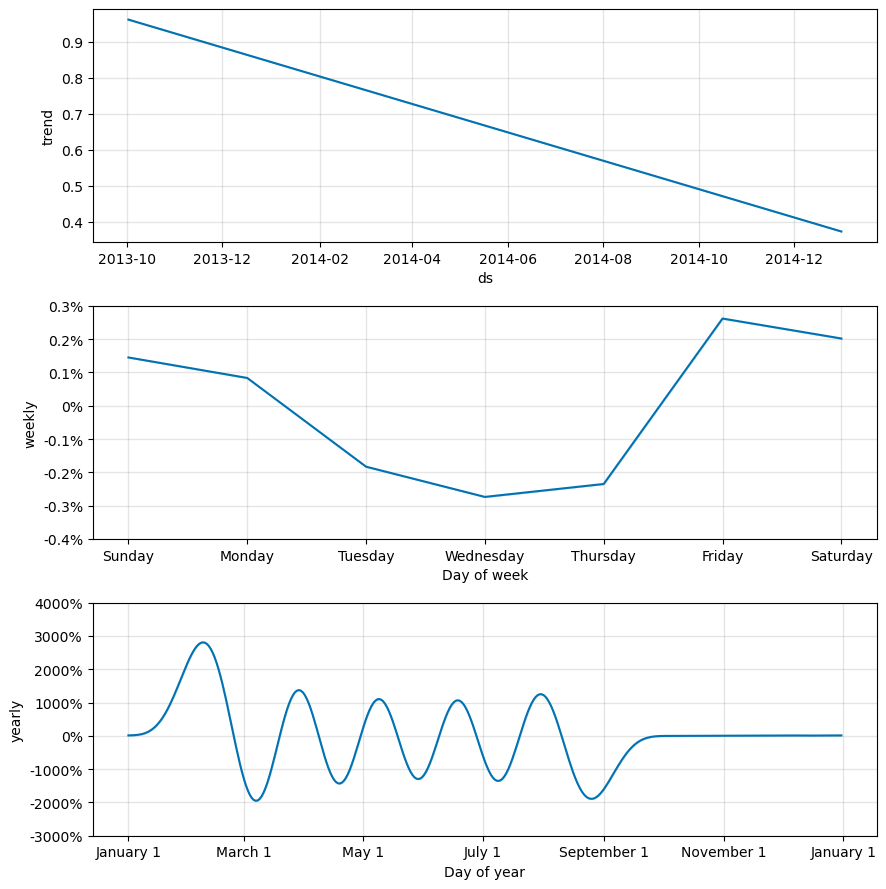

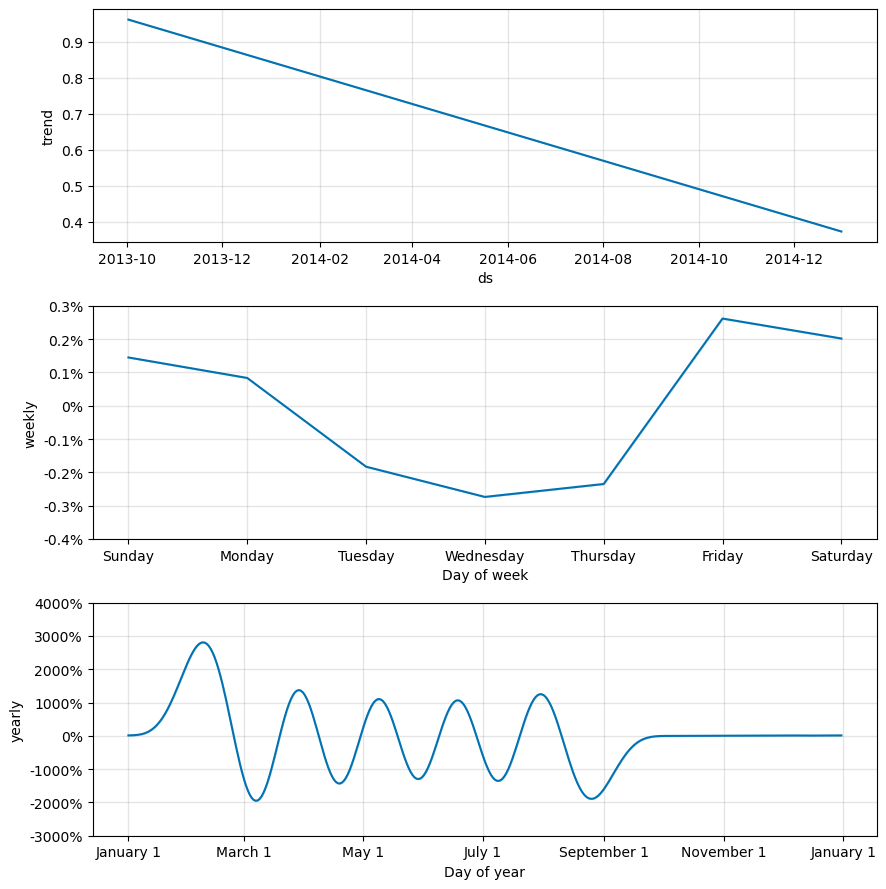

In [31]:
prophet.plot_components(prophet_forecasts[-1])

In [11]:
prophet_metrics

,mse,rmse,mae,mape
MNST,0.033756,0.183728,0.109248,0.074187
PCAR,0.138471,0.372117,0.335363,0.267789
MAR,0.177548,0.421364,0.344359,0.408106
PEP,0.010829,0.104062,0.079326,0.070397
ANSS,0.745597,0.863479,0.735714,0.572273
...,...,...,...,...
DHR,0.002577,0.050760,0.040594,0.038513
RTX,0.196260,0.443012,0.388458,0.346498
FTI,0.558551,0.747363,0.606683,0.389519
EMR,0.086647,0.294358,0.267315,0.237310


# Test model

Output()

0.02857307737120301


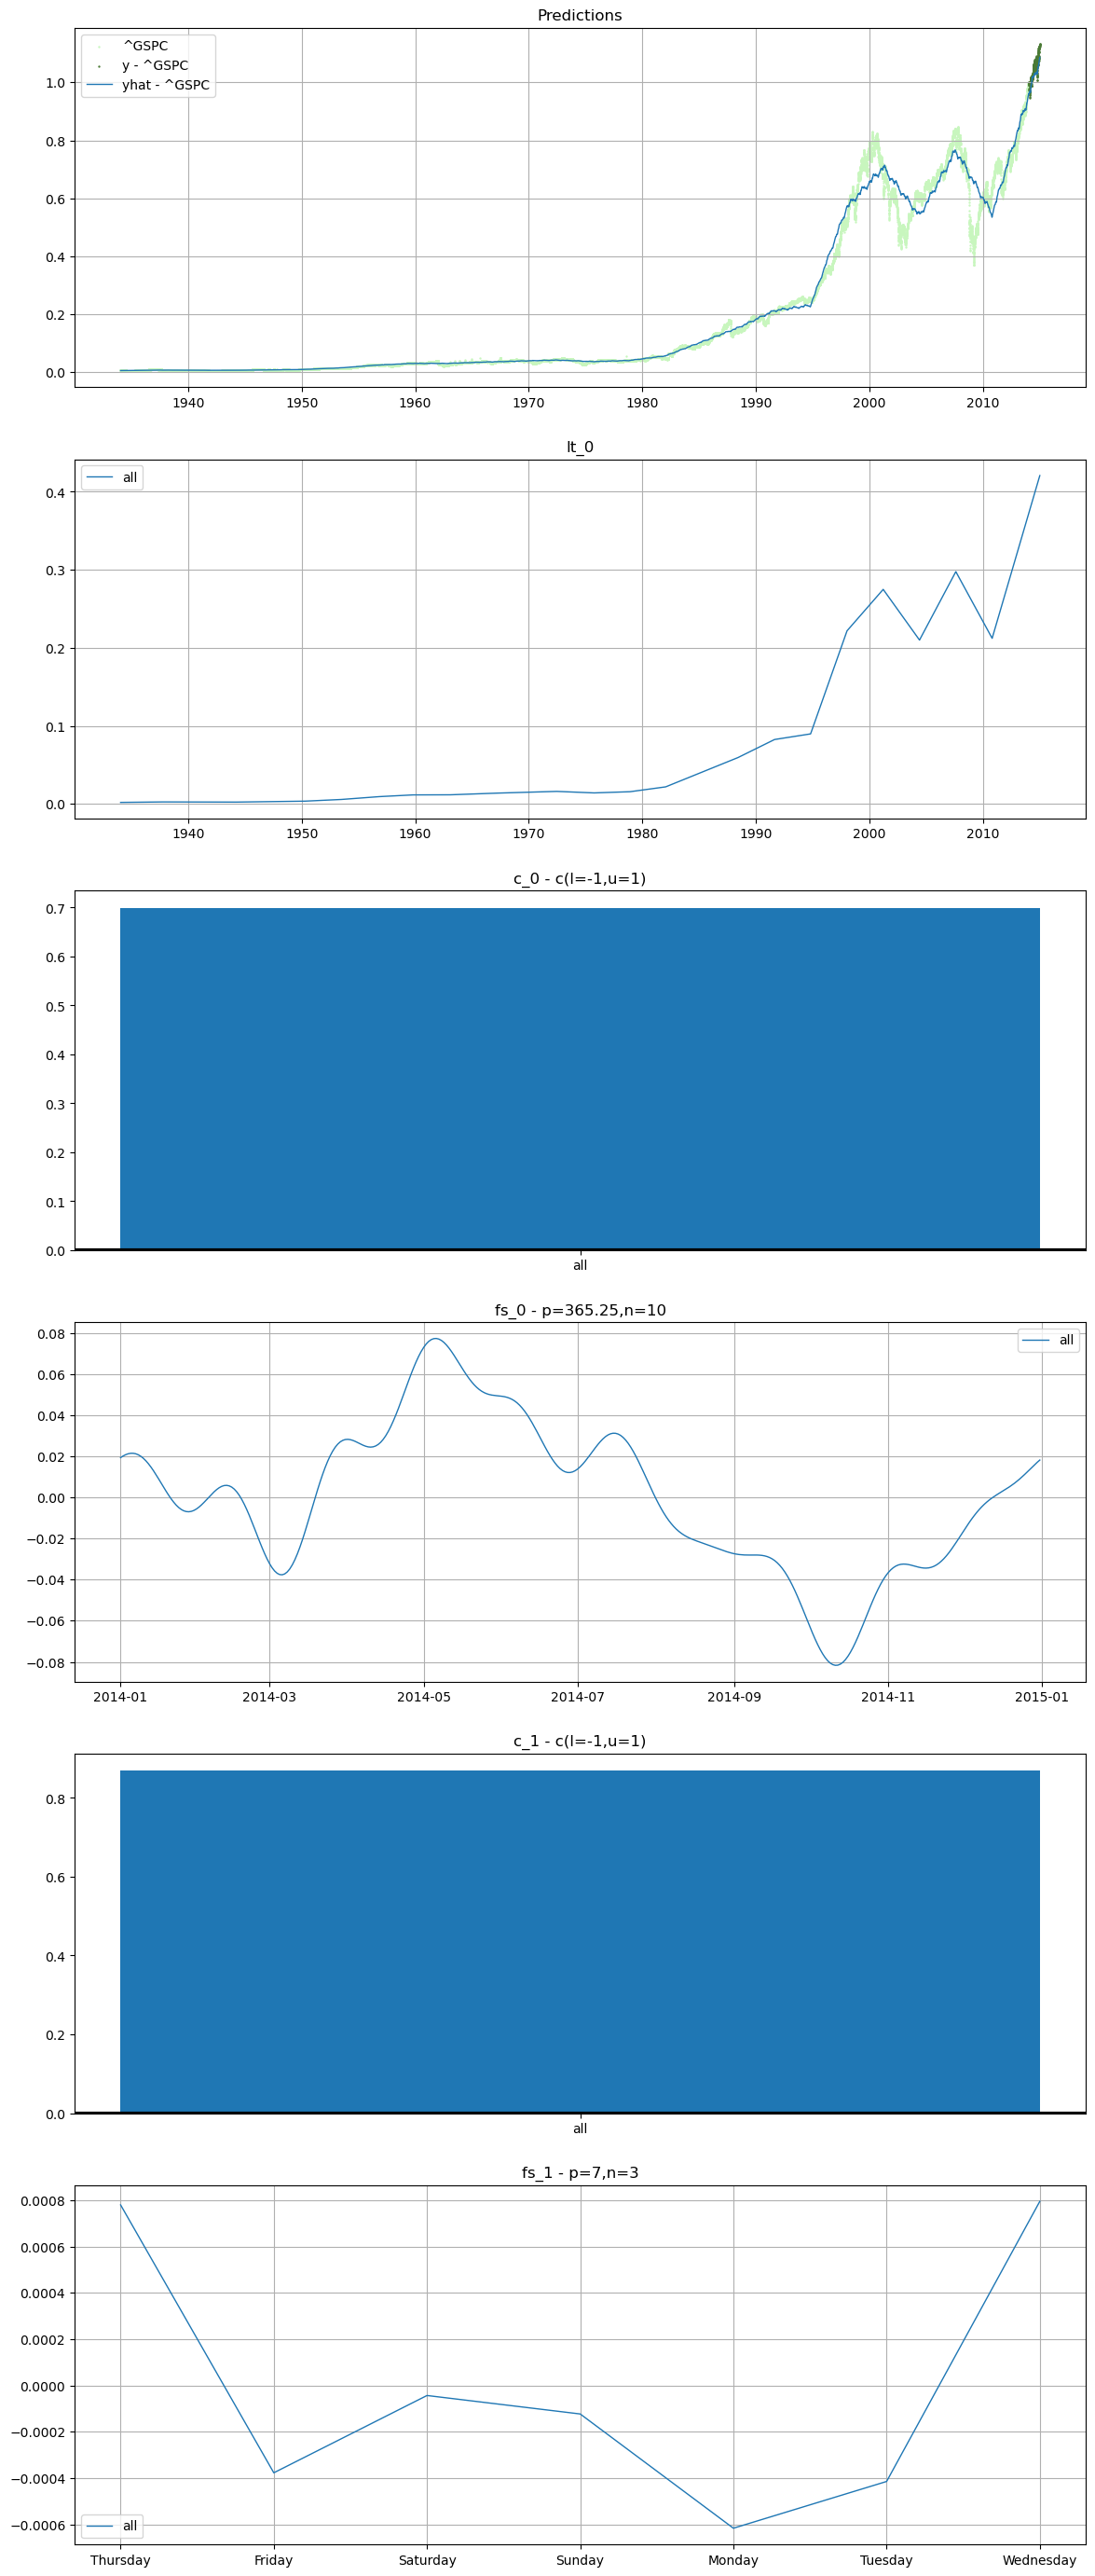

In [ ]:
model = LinearTrend(n_changepoints=25, changepoint_range=1, allow_tune=False) * (
    # Constant(-1, 1) * FourierSeasonality(365.25 * 10, 20, allow_tune=True)
    # + FourierSeasonality(365.25 * 5, 20, allow_tune=True)
    Constant(-1, 1) * FourierSeasonality(365.25, 10, allow_tune=True)
    # + FourierSeasonality(91.3125, 7, allow_tune=True)
    # + FourierSeasonality(30.4375, 5, allow_tune=True)
    + Constant(-1, 1) * FourierSeasonality(7, 3, allow_tune=False)
)
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 80, horizon=365, dfs=smp, for_prophet=False, point=point
)

model.fit(train_df_smp, mcmc_samples=0, nuts_sampler="numpyro")
yhat = model.predict(365)
print(model.metrics(test_df_smp, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_smp, pool_cols="series")
# model.fit_params["trace"].to_netcdf(Path("./") / "models" / "trace_80_c_y_c_w.nc")

In [ ]:
# model = LinearTrend(n_changepoints=25, changepoint_range=0.8, allow_tune=True) * (
#     FourierSeasonality(365.25, 10, allow_tune=True)
#     # + FourierSeasonality(91.3125, 7, allow_tune=True)
#     # + FourierSeasonality(30.4375, 5, allow_tune=True)
#     + FourierSeasonality(7, 3, allow_tune=False)
# )
model.load_trace(Path("./") / "models" / "trace_10.nc")
model.fit_params["map_approx"] = None
model.fit_params

{'map_approx': None,
 'trace': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

In [56]:
str(model.right.left.right.beta_sd)

'10'

In [57]:
model_metrics = []
point = "2014-01-01"
model.right.left.right.tune_method = "linear"

for gspc_ticker in tqdm(gspc_tickers):
    # if gspc_ticker["series"].iloc[0] not in good_stocks:
    #     continue
    
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is None:
        continue
    
    model.right.left.right.beta_sd = 0.01
    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

final_metrics = pd.concat(model_metrics)
final_metrics.to_csv("my_result_linear_2014_80.csv")
print(f"{model}: {final_metrics['mape'].mean()}")

 96%|█████████▋| 485/503 [37:03<01:16,  4.22s/it]